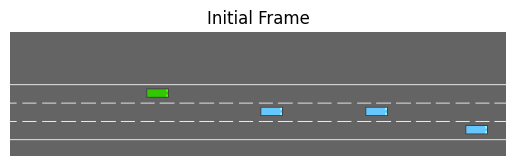

In [1]:
# Import libraries and make sure highway-env is installed properly
import gymnasium
import highway_env
import numpy as np
import matplotlib.pyplot as plt

# Create the environment with visual rendering
env = gymnasium.make("highway-fast-v0", render_mode="rgb_array")
obs, info = env.reset()

# Render and show the first frame
frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.title("Initial Frame")
plt.show()

env.close()

In [2]:
from pprint import pprint

# print the environment information
print("Environment Information:")
pprint(env.unwrapped.config)

Environment Information:
{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 30,
 'ego_spacing': 1.5,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 3,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 5,
 'vehicles_count': 20,
 'vehicles_density': 1}


In [3]:
import tensorboard
print(tensorboard.__version__)

2.17.1


In [4]:
# from highway_env.envs import HighwayEnv
# from gymnasium.envs.registration import EnvSpec
# import numpy as np

# class CustomHighwayFastEnv(HighwayEnv):
#     metadata = {"render_modes": ["rgb_array"], "render_fps": 15}

#     def __init__(self, base_config=None, render_mode=None):
#         if base_config is None:
#             base_config = {
#                 "observation": {
#                     "type": "Kinematics",
#                     "vehicles_count": 10,
#                     "features": ["x", "y", "vx", "vy"],
#                     "normalize": True,
#                 },
#                 "action": {"type": "DiscreteMetaAction"},
#                 "lanes_count": 4,
#                 "vehicles_count": 15,
#                 "duration": 40,
#                 "collision_reward": -1.0,
#                 "right_lane_reward": 0.0,
#                 "left_lane_reward": 0.0,
#                 "reward_speed_range": [20, 40],
#                 "offscreen_rendering": True,
#             }

#         if render_mode is not None:
#             base_config["render_mode"] = render_mode

#         # ✅ Set render_mode attribute before super().__init__()
#         self.render_mode = base_config.get("render_mode", None)

#         # ✅ PASS render_mode to parent constructor
#         super().__init__(config=base_config, render_mode=self.render_mode)

#         self.configure(base_config)
#         self.spec = EnvSpec("highway-fast-v0")

#     def reset(self, *args, **kwargs):
#         self.config["vehicles_count"] = np.random.randint(10, 35)
#         self.config["duration"] = np.random.randint(30, 50)
#         self.configure(self.config)
#         return super().reset(*args, **kwargs)


# # # env = gym.make("highway-fast-v0", render_mode="rgb_array", config={
# # #     "lanes_count": 4,
# # #     "vehicles_count": 40,
# # #     "duration": 50,
# # #     "collision_reward": -1.0,
# # #     "right_lane_reward": 0.5,
# # #     "left_lane_reward": -0.1,
# # # })
# # env = CustomHighwayFastEnv()
# # model = DQN(
# #     "MlpPolicy",
# #     env,
# #     buffer_size=15000,
# #     learning_rate=5e-4,
# #     policy_kwargs=dict(net_arch=[64, 64]),
# # )

# # model.learn(total_timesteps=20000, progress_bar=True)


In [5]:
# optuna trial for hyperparameter tuning
import optuna
import torch
import os
import json
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DQN

# Track best trial
best_trials = {}

def objective(trial):
    algorithm = "DQN"
    ModelClass = DQN
    # suggest hyperparameters for DQN: gamma, learning_rate, exploration_fraction,
    # network architecture, etc.
    gamma = trial.suggest_float("gamma", 0.85, 0.999)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    exploration_fraction = trial.suggest_float("exploration_fraction", 0.1, 0.5)
    net_arch = trial.suggest_categorical("net_arch", [[64, 64], [128, 128], [256, 256]])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    trial_log_dir = f"highway/DQN/optuna_trial_{trial.number}"
    os.makedirs(trial_log_dir, exist_ok=True)

    env = Monitor(CustomHighwayFastEnv())
    model = ModelClass(
        "MlpPolicy",
        env,
        gamma=gamma,
        learning_rate=learning_rate,
        exploration_fraction=exploration_fraction,
        policy_kwargs=dict(net_arch=net_arch),
        batch_size=batch_size,
        buffer_size=15000,
        verbose=1,
        tensorboard_log=trial_log_dir,
        learning_starts=1000,  # start learning after 1000 steps
    )
    # Training
    total_timesteps = 5000
    eval_interval = 1000  
    timesteps_run = 0


    while timesteps_run < total_timesteps:
        model.learn(
            total_timesteps=eval_interval,
            reset_num_timesteps=False,
            tb_log_name=f"{algorithm}_trial_{trial.number}",
            log_interval=1  # required to trigger logs
        )

        # Dump hyperparams to TensorBoard only once
        if timesteps_run == 0:
            for k, v in trial.params.items():
                model.logger.record(f"params/{k}", v)

        # ✅ Force log buffer to dump
        model.logger.dump(timesteps_run)

        timesteps_run += eval_interval
        print(f"Trial {trial.number}: Completed {timesteps_run} timesteps")

    # Final evaluation
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5, deterministic=True)
    env.close()

    trial.set_user_attr("mean_reward", mean_reward)
    if algorithm not in best_trials or trial.user_attrs["mean_reward"] > best_trials[algorithm].user_attrs["mean_reward"]:
        best_trials[algorithm] = trial
    return mean_reward

# study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
# study.optimize(objective, n_trials=15)

# # Save best results
# out_dir = "best_hyperparams/highway"
# os.makedirs(out_dir, exist_ok=True)

# for algo, trial in best_trials.items():
#     print(f"\n✅ Best trial ({trial}) for {algo}:")
#     print(f"Value (Mean reward): {trial.user_attrs['mean_reward']}")
#     print("Params:", trial.params)

#     with open(os.path.join(out_dir, f"{algo}.json"), "w") as f:
#         json.dump({
#             "value": trial.user_attrs["mean_reward"],
#             "params": trial.params
#         }, f, indent=2)


In [6]:
import gymnasium as gym

# === Create wrapped evaluation env ===
def make_env():
    # env = CustomHighwayFastEnv()
    env = gym.make("highway-fast-v0", render_mode="rgb_array")
    return Monitor(env)

In [7]:
import os
import json
from pprint import pprint

from stable_baselines3 import DQN  # or PPO/SAC/A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack
import gymnasium as gym

# === Load best hyperparameters ===
algo_name = "DQN"
ModelClass = DQN

with open(f"best_hyperparams/highway/{algo_name}.json", "r") as f:
    best_trial = json.load(f)

params = best_trial["params"]
policy_kwargs = dict(net_arch=params.pop("net_arch"))  # remove net_arch from params

pprint(f"Best hyperparameters for {algo_name}: {params}")

num_cpus = os.cpu_count()
print("🧠 CPU cores available:", num_cpus)

# Make and stack envs
base_env = make_vec_env(make_env, n_envs=num_cpus)
train_env = VecFrameStack(base_env, n_stack=4, channels_order="last")  # <- 🔁 Frame stacking

pprint(train_env.observation_space)
pprint(train_env.action_space)
pprint(train_env.envs[0].unwrapped.config)
# === Model instantiation ===
algo_postfix = "_".join(map(str, policy_kwargs["net_arch"])) + "_stack4_40k"
model_name = f"{algo_name}_tuned{algo_postfix}"

model = ModelClass(
    "MlpPolicy",
    train_env,
    verbose=1,
    learning_starts=2000,  
    tensorboard_log=f"runs/highway/{model_name}",
    policy_kwargs=policy_kwargs,
    **params,
)

# === Training loop with checkpointing ===
total_timesteps = 40000
save_interval = 10000
timesteps_run = 0

cp_log_dir = f"checkpoints/highway/{model_name}"
os.makedirs(cp_log_dir, exist_ok=True)

while timesteps_run < total_timesteps:
    model.learn(
        total_timesteps=save_interval,
        reset_num_timesteps=False,
        tb_log_name=f"highway_tuned_{model_name}",
        log_interval=1,
    )
    timesteps_run += save_interval
    model.save(f"{cp_log_dir}/{timesteps_run}")
    print(f"✅ Saved checkpoint at {timesteps_run} timesteps")

# === Save final model ===
final_model_path = f"models/highway/{model_name}_trained"
model.save(final_model_path)
print(f"✅ Final model saved at {final_model_path}")


("Best hyperparameters for DQN: {'gamma': 0.905806477708257, 'learning_rate': "
 "0.0007969454818643932, 'exploration_fraction': 0.39279757672456206, "
 "'batch_size': 64}")
🧠 CPU cores available: 20
Box(-inf, inf, (5, 20), float32)
Discrete(5)
{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 30,
 'ego_spacing': 1.5,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 3,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 5,
 'vehicles_co

In [8]:
import os
import numpy as np
import imageio
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
import gymnasium as gym
from IPython.display import Video

# === Configuration ===
algo_name = "DQN"
model_name = "DQN_tuned64_64_stack4_40k"
video_eval_dir = f"tuned/highway/{algo_name}_tuned/video_eval"
os.makedirs(video_eval_dir, exist_ok=True)
video_path = os.path.join(video_eval_dir, f"{algo_name}_eval_stacked.mp4")

# === Load trained model ===
model = DQN.load(f"models/highway/{model_name}_trained")

# === Create vectorized, stacked env for model input ===
def make_model_env():
    def _init():
        env = gym.make("highway-fast-v0", render_mode=None)
        env.unwrapped.config["duration"] = 500
        env.unwrapped.configure(env.unwrapped.config)
        return Monitor(env)
    return _init

stacked_eval_env = VecFrameStack(DummyVecEnv([make_model_env()]), n_stack=4, channels_order="last")

# === Create a separate env for rendering only (no stacking) ===
render_env = gym.make("highway-fast-v0", render_mode="rgb_array")
render_env.unwrapped.config["duration"] = 500
render_env.unwrapped.configure(render_env.unwrapped.config)
render_env = Monitor(render_env)



# === Evaluate and collect frames ===
frames = []
num_episodes = 5  # Number of episodes to evaluate

for i in range(num_episodes):
    # === Synchronize the two environments ===
    obs_stacked = stacked_eval_env.reset()
    obs_render, _ = render_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs_stacked)
        obs_stacked, _, done, _ = stacked_eval_env.step(action)
        obs_render, _, terminated, truncated, _ = render_env.step(action[0])
        frame = render_env.render()
        frames.append(frame)
        if terminated or truncated:
            break

    # Add a few idle frames for padding
    for _ in range(10):
        frames.append(frames[-1])

# === Save video ===
imageio.mimsave(video_path, frames, fps=30)

# === Display video ===
Video(video_path, embed=True, width=600, height=400)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 150) to (608, 160) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
